In [2]:
%matplotlib inline
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from dataset_utils import load_img, img_to_dataset, grid_plot

from tensorflow import keras as K
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## loading the data

In [4]:
data_source = '/net/people/plgmatisz/antibodies/data/original/'
glob.glob(data_source + '*')

['/net/people/plgmatisz/antibodies/data/original/negatives',
 '/net/people/plgmatisz/antibodies/data/original/AMA',
 '/net/people/plgmatisz/antibodies/data/original/nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+homogenny',
 '/net/people/plgmatisz/antibodies/data/original/ACA',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty',
 '/net/people/plgmatisz/antibodies/data/original/fibrilar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/homogenous',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+cytoplazmatyczny',
 '/net/people/plgmatisz/antibodies/data/original/nuclear_dots']

In [5]:
classes_to_load = {
    'ZIA': 'ziarnisty',
    'HOM': 'homogenous'
}

files_limit = 100

files_dict = {key: glob.glob(f'{data_source}/{dir_}/*')[:files_limit] for key, dir_ in classes_to_load.items()}

for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

ZIA: 100
HOM: 70


CPU times: user 1.66 s, sys: 376 ms, total: 2.03 s
Wall time: 2.06 s


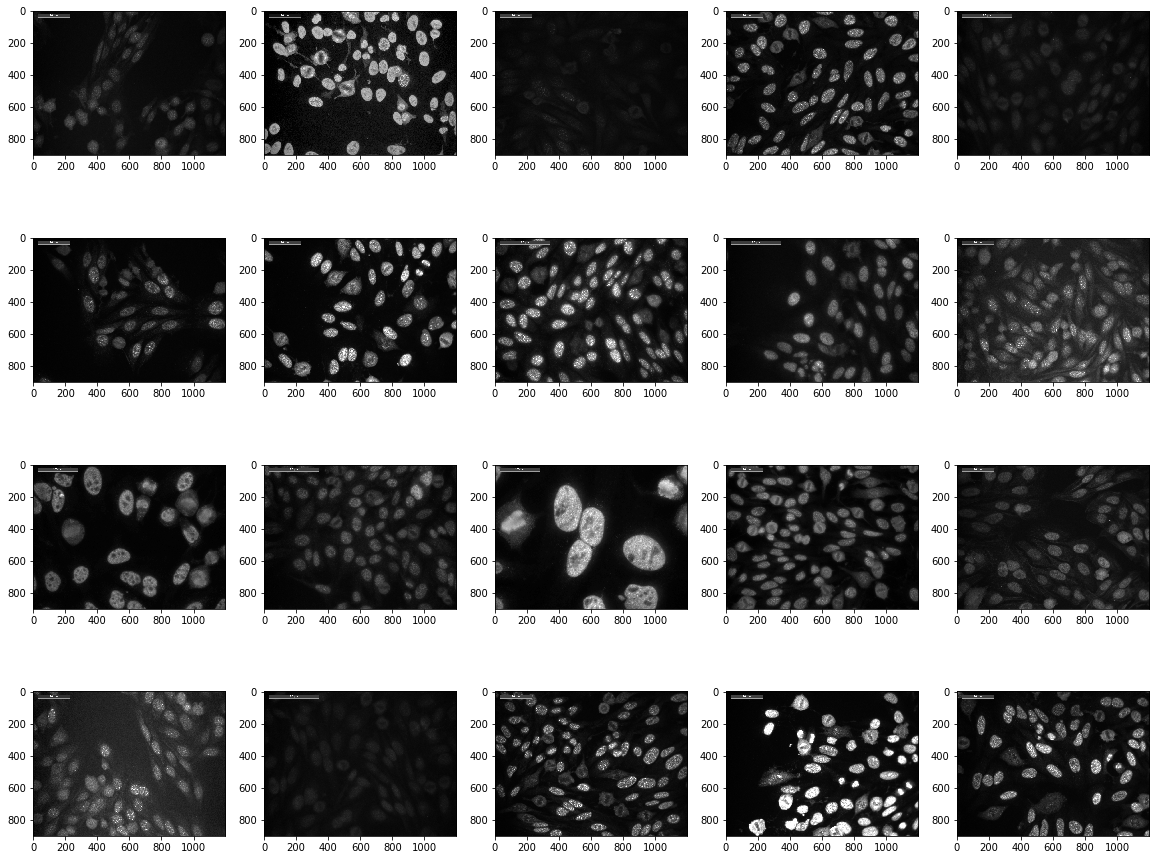

In [7]:
%%time

img_size = (1200, 900)

imgs_dict = {key: np.array([load_img(f, img_size, grayscale=True) for f in files]) for key, files in files_dict.items()}

plt.figure(figsize=(20, 16))
grid_plot(imgs_dict['ZIA'], 4, 5, method='imshow', cmap='gray')

## defining datasets

In [8]:
%%time

params = {
    
    # params for detecting ROI
    'roi_window_size': 20,
    'roi_stride': 5,
    'roi_threshold': 3.,
    
    # params for extracting dataset windows
    'img_window_size': 128,
    'img_window_stride': 24,
    'img_neg_threshold': 0.05,
    'img_pos_threshold': 0.7
}

hom_imgs = imgs_dict['HOM']
zia_imgs = imgs_dict['ZIA']


train_imgs_count = 20
test_imgs_count = 8

hom_train_datasets = [img_to_dataset(img, params) for img in hom_imgs[:train_imgs_count]]
hom_test_datasets = [img_to_dataset(img, params) for img in hom_imgs[-test_imgs_count:]]

zia_train_datasets = [img_to_dataset(img, params) for img in zia_imgs[:train_imgs_count]]
zia_test_datasets = [img_to_dataset(img, params) for img in zia_imgs[-test_imgs_count:]]

hom_train = np.concatenate([ds[1] for ds in hom_train_datasets])
hom_test = np.concatenate([ds[1] for ds in hom_test_datasets])

zia_train = np.concatenate([ds[1] for ds in zia_train_datasets])
zia_test = np.concatenate([ds[1] for ds in zia_test_datasets])

print(f'hom: train - {hom_train.shape}, test - {hom_test.shape}')
print(f'zia: train - {zia_train.shape}, test - {zia_test.shape}')

hom: train - (7112, 128, 128), test - (4261, 128, 128)
zia: train - (8071, 128, 128), test - (3504, 128, 128)
CPU times: user 15.3 s, sys: 10.7 s, total: 26 s
Wall time: 26 s


[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]


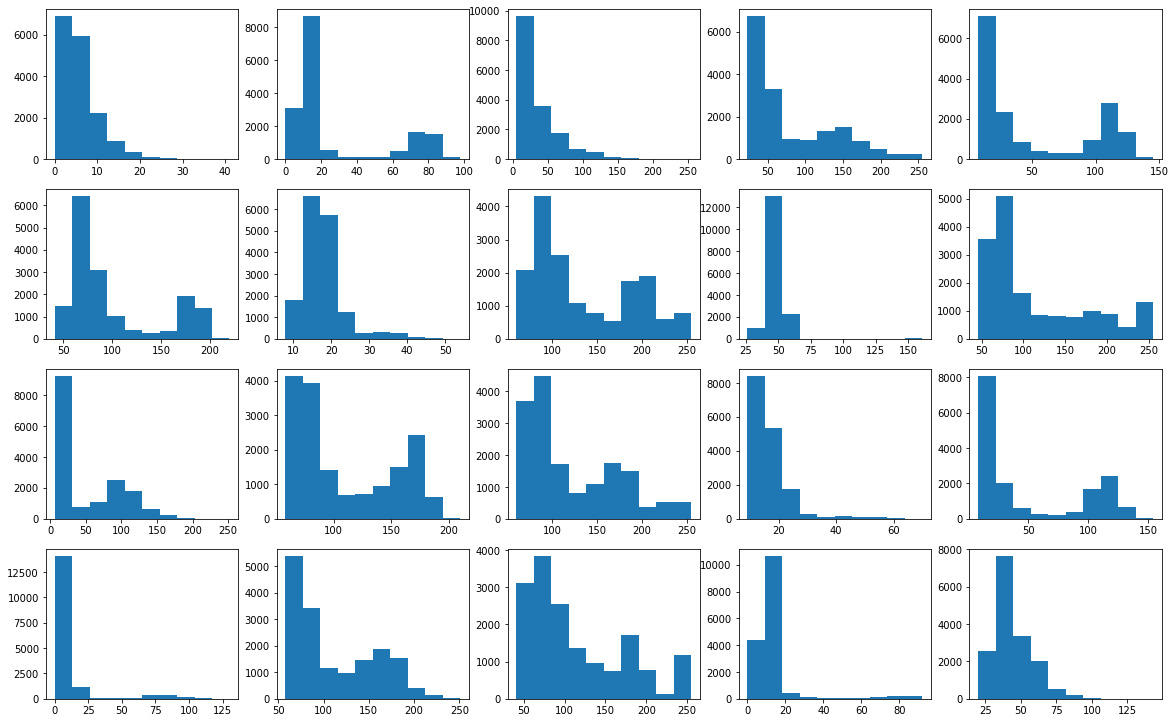

In [9]:
train_samples_per_class = 7_000
test_samples_per_class = 2_000

X_train = np.concatenate([hom_train[:train_samples_per_class], zia_train[:train_samples_per_class]])
X_test = np.concatenate([hom_test[:test_samples_per_class], zia_test[:test_samples_per_class]])

y_train = np.concatenate([
    np.zeros(train_samples_per_class),
    np.ones(train_samples_per_class)
])

y_test = np.concatenate([
    np.zeros(test_samples_per_class),
    np.ones(test_samples_per_class)
])

train_indeces = np.array(range(X_train.shape[0]))
rand_train_indeces = np.random.choice(train_indeces, 20)

plt.figure(figsize=(20, 16))
grid_plot(X_train[rand_train_indeces].reshape(-1, 128*128), method='hist')#, cmap='gray')

print(y_train[rand_train_indeces])

## network training

In [10]:
from tensorflow.keras.applications import resnet_v2, inception_v3

In [11]:
input_tensor = K.layers.Input(shape=(params['img_window_size'], params['img_window_size'], 3))
base_model = inception_v3.InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
model_top = K.layers.Flatten()(base_model.output)
model_top = K.layers.Dense(1, activation='sigmoid')(model_top)

In [13]:
full_model = K.Model(base_model.input, model_top, name='cells-transfer')
full_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [14]:
%%time

X_train_prep = X_train.copy()
X_train_prep = np.repeat(X_train_prep[..., np.newaxis], 3, -1)
np.apply_along_axis(resnet_v2.preprocess_input, arr=X_train_prep, axis=0)

X_test_prep = X_test.copy()
X_test_prep = np.repeat(X_test_prep[..., np.newaxis], 3, -1)
np.apply_along_axis(resnet_v2.preprocess_input, arr=X_test_prep, axis=0)

print()


CPU times: user 51.5 s, sys: 3.87 s, total: 55.4 s
Wall time: 55.4 s


In [15]:
X_train_prep.shape

(14000, 128, 128, 3)

In [19]:
base_model.trainable = True
full_model.compile(optimizer=K.optimizers.Adam(learning_rate=0.001),
                   loss='binary_crossentropy', metrics=['accuracy'])

full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [20]:
history = full_model.fit(
    X_train_prep, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_test_prep, y_test)
)

Train on 14000 samples, validate on 4000 samples
Epoch 1/30
14000/14000 [==============================] - 72s 5ms/sample - loss: 0.1855 - accuracy: 0.9487 - val_loss: 31.9401 - val_accuracy: 0.5982
Epoch 2/30
14000/14000 [==============================] - 54s 4ms/sample - loss: 0.0272 - accuracy: 0.9887 - val_loss: 0.1509 - val_accuracy: 0.9660
Epoch 3/30
14000/14000 [==============================] - 54s 4ms/sample - loss: 0.0269 - accuracy: 0.9890 - val_loss: 0.5350 - val_accuracy: 0.8863
Epoch 4/30
14000/14000 [==============================] - 54s 4ms/sample - loss: 0.1113 - accuracy: 0.9749 - val_loss: 1710.2923 - val_accuracy: 0.4985
Epoch 5/30
14000/14000 [==============================] - 54s 4ms/sample - loss: 0.0367 - accuracy: 0.9869 - val_loss: 0.3418 - val_accuracy: 0.8960
Epoch 6/30
14000/14000 [==============================] - 54s 4ms/sample - loss: 0.0204 - accuracy: 0.9924 - val_loss: 0.1776 - val_accuracy: 0.9678
Epoch 7/30
14000/14000 [=============================

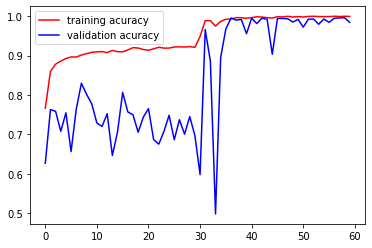

In [21]:
acc = np.concatenate([acc, history.history['accuracy']])
val_acc = np.concatenate([val_acc, history.history['val_accuracy']])

plt.plot(acc, c='red', label='training acuracy')
plt.plot(val_acc, c='blue', label='validation acuracy')
plt.legend()

In [23]:
pred_test = full_model.predict(X_test_prep).reshape(-1)

In [41]:
comparison = (pred_test > 0.5) != y_test

incorrect = np.argwhere(comparison).reshape(-1)
incorrect.shape

(62,)

In [42]:
X_test_incorrect = X_test[incorrect]
X_test_incorrect.shape

(62, 128, 128)

In [44]:
incorrect

array([ 207,  208,  209,  210,  211,  215,  216,  253,  254,  255,  261,
        298,  299,  672,  673,  718,  756,  891, 2930, 2931, 3014, 3066,
       3111, 3486, 3542, 3677, 3678, 3679, 3680, 3686, 3687, 3688, 3689,
       3695, 3696, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3722, 3723,
       3724, 3746, 3747, 3748, 3750, 3779, 3780, 3817, 3825, 3851, 3870,
       3937, 3956, 3957, 3958, 3979, 3980, 3981])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0.98 1.   1.   1.   0.77 0.66 0.98 0.98 1.   0.71 0.53 0.99 1.   0.82
 1.   0.84 0.83 0.84 0.06 0.01 0.35 0.12 0.02 0.12 0.03 0.   0.   0.15
 0.18 0.01 0.   0.   0.31 0.08 0.02 0.01 0.   0.   0.21 0.02 0.03 0.
 0.05 0.19 0.39 0.31 0.02 0.42 0.22 0.25]


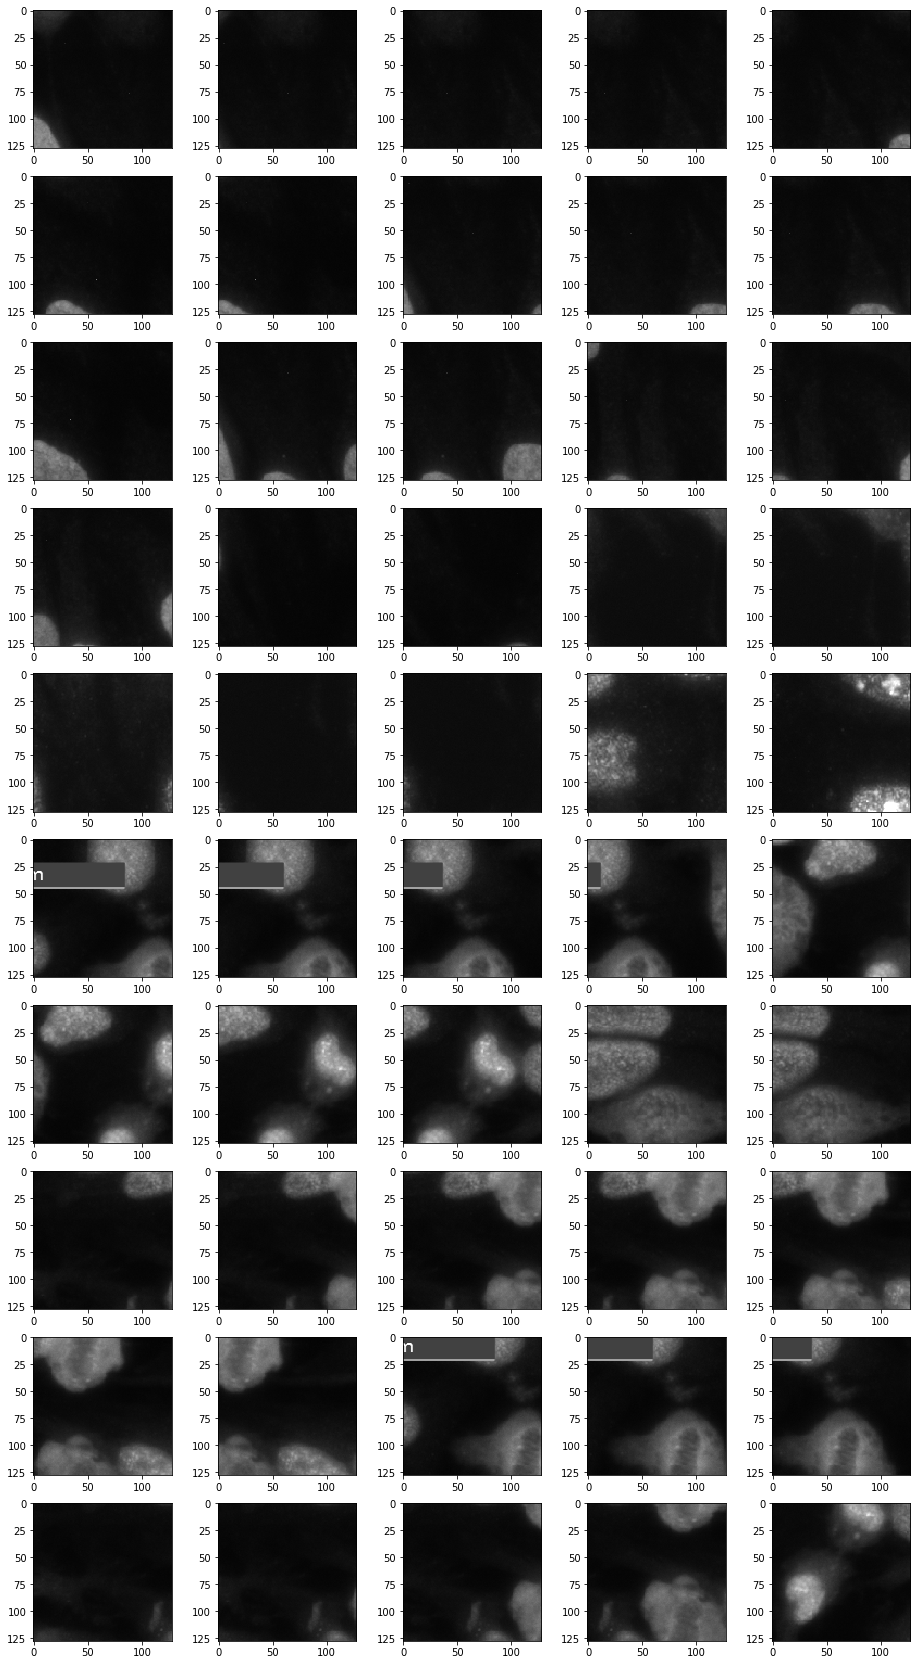

In [43]:

plt.figure(figsize=(16, 30))
grid_plot(X_test[incorrect], 10, 5, vmin=0, vmax=255, cmap='gray')

print(y_test[incorrect][:50])
print(np.round(pred_test[incorrect][:50], decimals=2))

In [26]:
y_test

array([0., 0., 0., ..., 1., 1., 1.])

In [33]:
(pred_test > 0.5).astype(np.uint8) == y_test

array([ True,  True,  True, ...,  True,  True,  True])